In [388]:
%%html
<style type="text/css">
  span.ecb { background: yellow; }
</style>

# ATMO 5331 - Homework 3 - Fall 2021
## Due 5 Oct, 2021

When doing this homework, remember that you have two jobs:
1. Make it work.
2. Clean it up so that I can understand what you've done. If you think I might not understand, document it with a comment or a function docstring.

You should present your work with a clear logical progression. If that seems like a hassle, remember that in doing so you are practicing skills that are expected in your thesis and journal publications.

You may work alone or in pairs. I will not be adjudicating relative level of effort in group work, so you are responsible for ensuring that you and your partner contribute equally.

<span class="ecb">Comments by ECB</span>

In [389]:
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [390]:
import sys
print(sys.path)

['/Users/stephanievoelker', '/Users/stephanievoelker/miniconda3/lib/python39.zip', '/Users/stephanievoelker/miniconda3/lib/python3.9', '/Users/stephanievoelker/miniconda3/lib/python3.9/lib-dynload', '', '/Users/stephanievoelker/miniconda3/lib/python3.9/site-packages', '/Users/stephanievoelker/miniconda3/lib/python3.9/site-packages/IPython/extensions', '/Users/stephanievoelker/.ipython']


For this assignment, download some [sample Ka data](http://www.atmo.ttu.edu/bruning/5331/Ka2140614021408.RAWPXA9.nc). These data were converted directly from the raw format collected by the radar (Sigmet) to the [NetCDF CF/Radial standard](http://ncar.github.io/CfRadial/). No further processing has been applied.

In the file, the radar variables (such as reflectivity) are stored in arrays with dimension `(time, range)`. At each time, a single ray of data is collected, which extends along range. There is also a `sweep` dimension that corresponds to a few different variables. These variables mark the start and the end of each radar scan. Let's look at that structure:

In [391]:
# d = xr.open_dataset('../../../cfrad.20080604_002217_000_SPOL_v36_SUR.nc')

# defining d, using the path of the dowloaded file
d = xr.open_dataset('/Users/stephanievoelker/Downloads/Ka2140614021408.RAWPXA9.nc')

print(d)

# Print the first ten elevation angles.
print(d.variables['elevation'][0:10])

# Shortcut to variable access
print(d.elevation[0:10])

<xarray.Dataset>
Dimensions:                    (time: 2938, range: 1666, sweep: 5)
Coordinates:
  * time                       (time) datetime64[ns] 2014-06-14T02:14:19 ... ...
  * range                      (range) float32 0.0 15.0 ... 2.496e+04 2.498e+04
    azimuth                    (time) float32 ...
    elevation                  (time) float32 ...
Dimensions without coordinates: sweep
Data variables: (12/25)
    total_power                (time, range) float32 ...
    reflectivity               (time, range) float32 ...
    velocity                   (time, range) float32 ...
    spectrum_width             (time, range) float32 ...
    normalized_coherent_power  (time, range) float32 ...
    sweep_number               (sweep) int32 ...
    ...                         ...
    longitude                  float64 ...
    altitude                   float64 ...
    time_coverage_start        |S32 ...
    time_coverage_end          |S32 ...
    time_reference             |S32 ...
    

<xarray.DataArray 'sweep_mode' (sweep: 5)>
array([b'rhi', b'rhi', b'rhi', b'rhi', b'rhi'], dtype='|S32')
Dimensions without coordinates: sweep
Attributes:
    long_name:      Sweep mode
    units:          unitless
    standard_name:  sweep_mode
    comment:        Options are: "sector", "coplane", "rhi", "vertical_pointi...
<xarray.DataArray 'sweep_start_ray_index' (sweep: 5)>
array([   0,  590, 1176, 1766, 2352], dtype=int32)
Dimensions without coordinates: sweep
Attributes:
    long_name:  Index of first ray in sweep, 0-based
    units:      count
<xarray.DataArray 'sweep_end_ray_index' (sweep: 5)>
array([ 589, 1175, 1765, 2351, 2937], dtype=int32)
Dimensions without coordinates: sweep
Attributes:
    long_name:  Index of last ray in sweep, 0-based
    units:      count


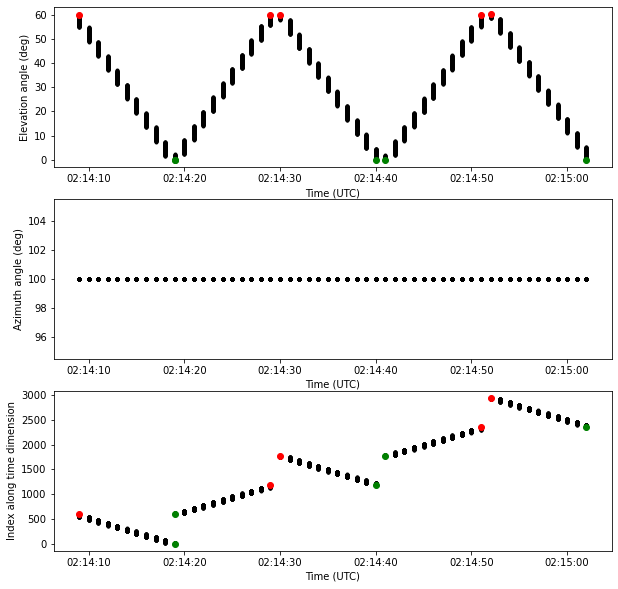

In [392]:
# this code was given

print(d.sweep_mode)
print(d.sweep_start_ray_index)
print(d.sweep_end_ray_index)

az = d.azimuth[:]
el = d.elevation[:]
t = d.time[:]
fig, axs = plt.subplots(3,1, squeeze=False, figsize=(10,10))

axs[0,0].plot(t,el, '.k')
axs[0,0].set_ylabel('Elevation angle (deg)')
axs[0,0].set_xlabel('Time (UTC)')
axs[1,0].plot(t,az, '.k')
axs[1,0].set_ylabel('Azimuth angle (deg)')
axs[1,0].set_xlabel('Time (UTC)')
axs[2,0].plot(t, np.arange(t.shape[0]), '.k')
axs[2,0].set_ylabel('Index along time dimension')
axs[2,0].set_xlabel('Time (UTC)')
for sw_start, sw_end in zip(d.sweep_start_ray_index, d.sweep_end_ray_index):
    axs[0,0].plot(t[sw_start], el[sw_start], marker='o', color='g')
    axs[0,0].plot(t[sw_end], el[sw_end], marker='o',color='r')
    axs[2,0].plot(t[sw_start], sw_start, marker='o', color='g')
    axs[2,0].plot(t[sw_end], sw_end, marker='o',color='r')

The green dots mark the start of a sweep according to `sweep_start_ray_index`, and red marks the end according to `sweep_end_ray_index`. We observe that:

0. the scans are in [RHI](http://ww2010.atmos.uiuc.edu/(Gh)/guides/rs/rad/basics/cnmod.rxml) mode, per the scan_mode variable.
1. the data have time precision of 1 s
2. the data are not stored in time order.
3. the data are stored in the file in order of increasing elevation angle, not increasing time.
4. azimuth angle is constant.

For the rest of this assignment, let's work with the second of the five scans, where time and elevation both increase with index along the time dimension. Reuse this variable instead of hard-coding a scan number in later code.

In [393]:
scan_idx = 1

**1.** Let's start by preparing the coordinates needed to plot a scan. Write a function that takes a radar dataset and scan index, and returns  1D arrays of ranges, azimuths, and elevations that correspond to the edges of each radar sample (a.k.a., each gate). Your function should return three separate 1d variables, as you see in the sample function call below. I found it helpful to visualize how the coordinates were distributed in 2D a quick, unlableled plot of each coordinate: `plt.imshow(r)`.

In [394]:
# function that takes the dataset and scan index
# returns 1D arrays of range, azimuth, and elevation
def coords1D(data1, scan_idx1):
    start_in = data1.sweep_start_ray_index[scan_idx].values
    end_in = data1.sweep_end_ray_index[scan_idx].values
    r_1D = data1.range.values
    az_1D = data1.azimuth[start_in:end_in+1].values
    el_1D = data1.elevation[start_in:end_in+1].values
    return r_1D, az_1D, el_1D
    
r_1D, az_1D, el_1D = coords1D(d, scan_idx)
#print(r_1D, az_1D, el_1D)

# converts center to edges
def centers_to_edges_1d(x):
    x_edges = x.shape[0]+1
    x_e = np.zeros(x_edges)
    x_e[1:-1] = (x[1:]+x[:-1])/2
    x_e[0] = x[0] -(x[1]-x[0])/2
    x_e[-1] = x[-1] + (x[-1] - x[-2])/2
    return x_e

new_r_1D = centers_to_edges_1d(r_1D)
new_el_1D = centers_to_edges_1d(el_1D)

# function that takes the dataset and scan index
# returns 2D arrays of range, azimuth, and elevation
# I commented out part of the code because it was causing issues
#def coords2D(data1, scan_idx1):
r_2D, el_2D = np.meshgrid(new_r_1D, new_el_1D)
    #r_2D, el_2D = np.meshgrid(new_r_1D, new_el_1D)
    #return r_2D, el_2D

#r_2D, el_2D = coords2D(d, scan_idx)
az_2D = np.full_like(el_2D, az_1D[0])

# number of values in each array
print(r_2D.shape)
print(el_2D.shape)

#1666 number of range value in your array
#586 number of azimuth and elevation values

(587, 1667)
(587, 1667)


<span class="ecb">I did ask for the coords2D function; happy to visit about what was going wrong. -1 </span>

**2.** Make a 4-panel plot of reflectivity, velocity, spectrum width, and normalized coherent power. Use `coordinateSystems.RadarCoordinateSystem` to plot in altitude above vs. range along a tangent plane. The tangent plane should be centered at the location of radar.

Note that if you find that the coordinate transformations fail to preserve the shape of your input coordinate arrays, you can fix it with `X.shape = r.shape`, where `X` has been transformed from `r`.

<IPython.core.display.Javascript object>


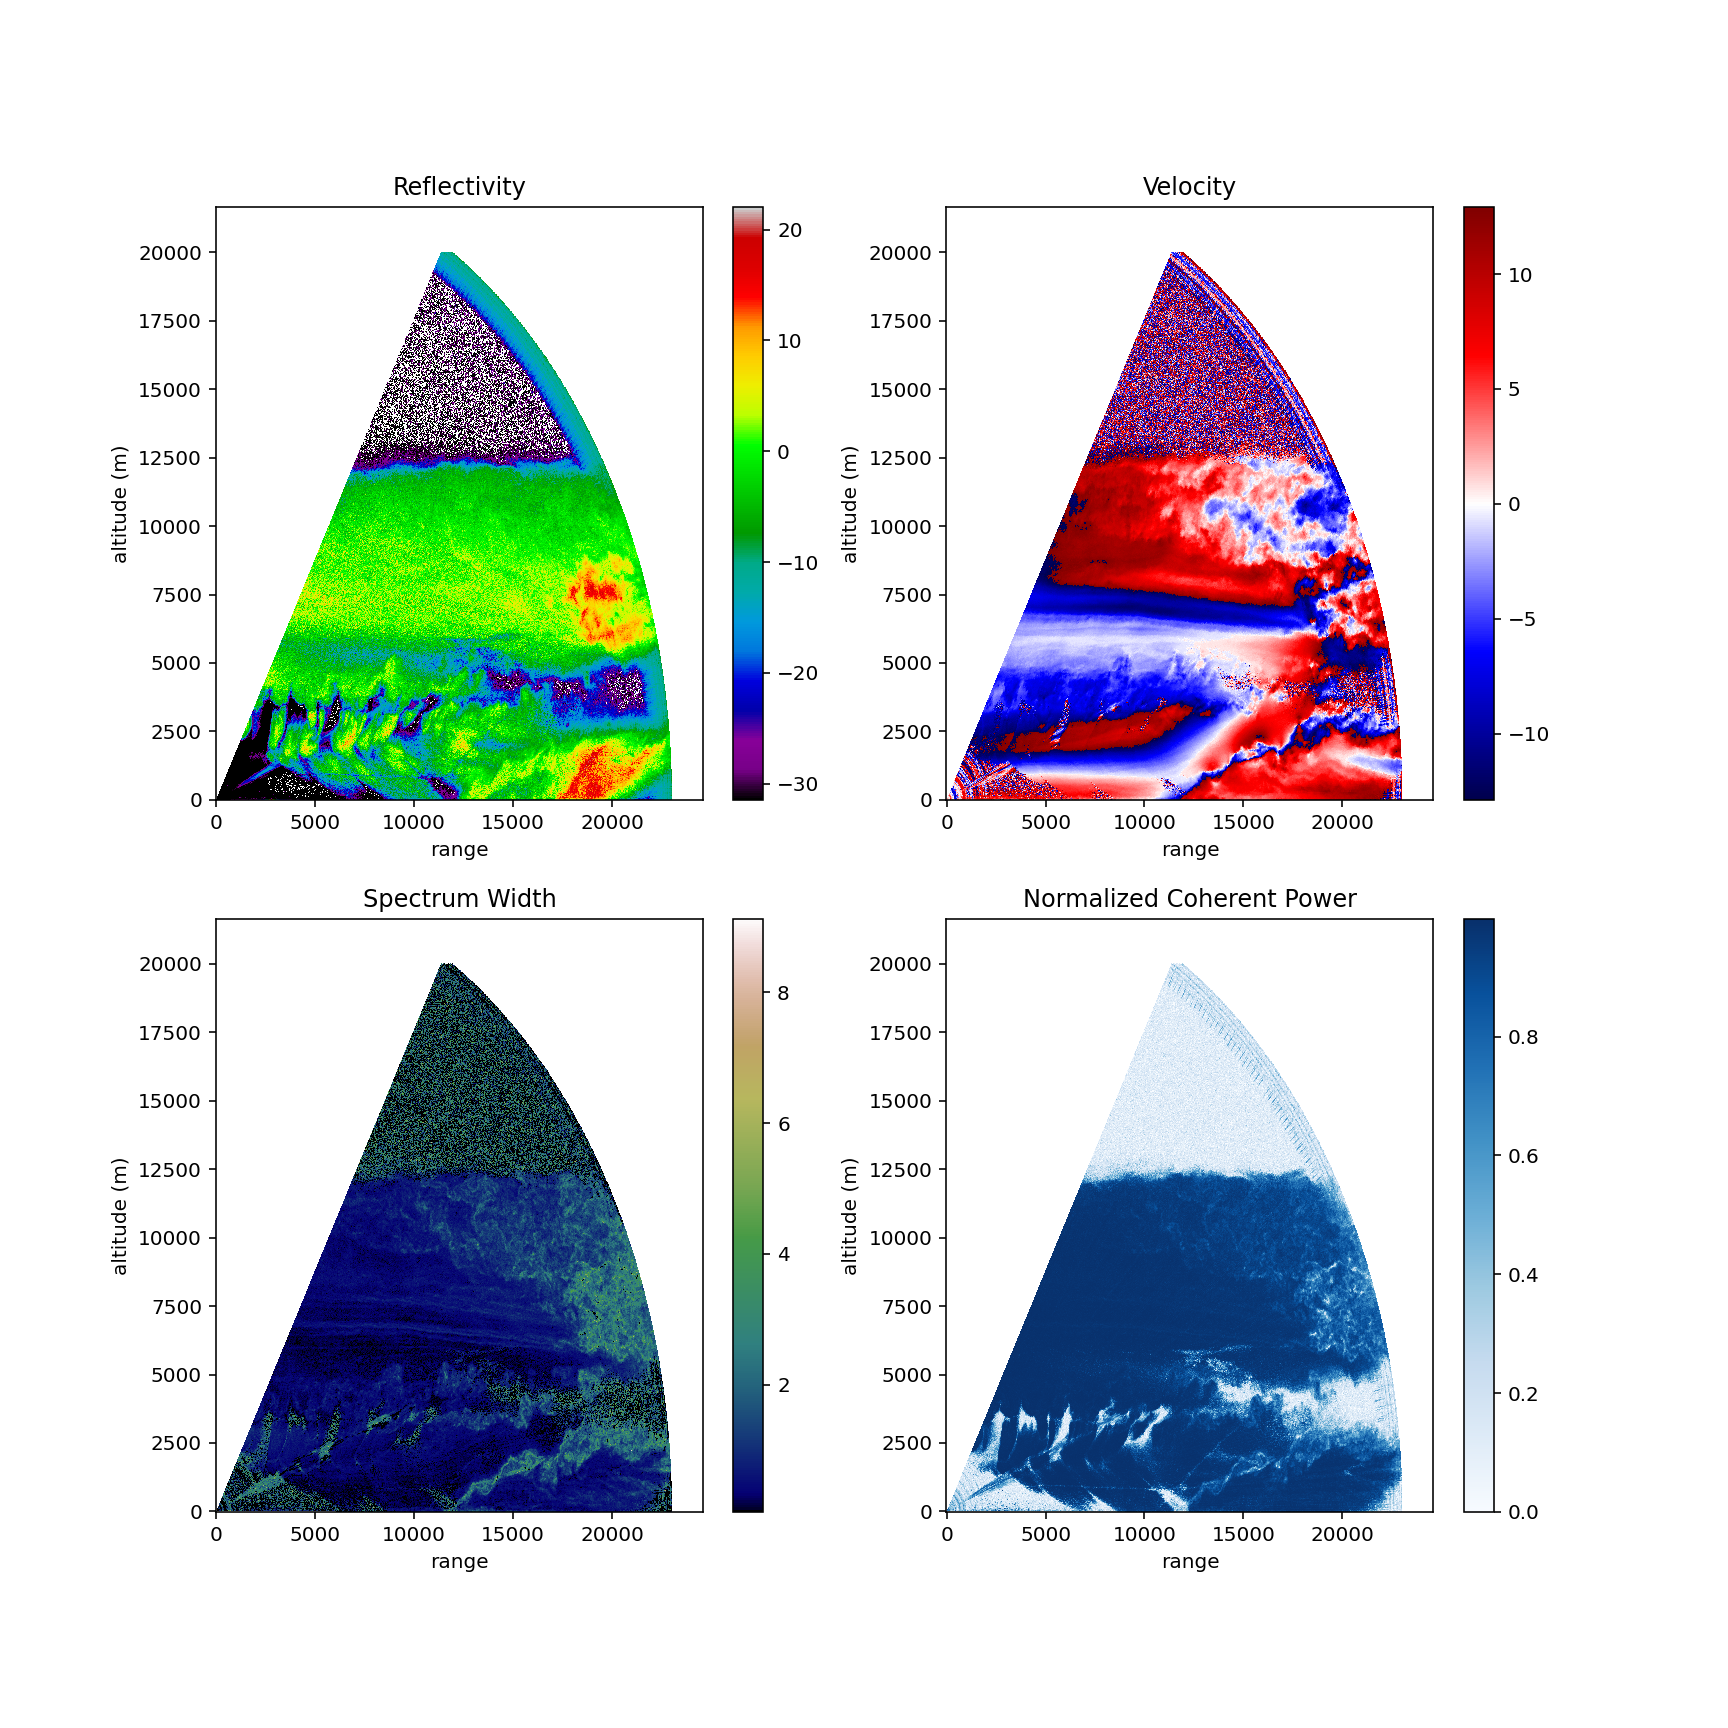

Text(0.5, 1.0, 'Normalized Coherent Power')

In [395]:
# importing necassary functions
from coordinateSystems import RadarCoordinateSystem
from coordinateSystems import TangentPlaneCartesianSystem

# the following code was based off code that I used in homework 1

# making arrays for lon, lat, altitude
lon1 = np.array(d.longitude)
lat1 = np.array(d.latitude)
alt1 = np.array(d.altitude)

# creating a tangent using lat, lon, alt with radar coords
r_coords = RadarCoordinateSystem(lat1, lon1, alt1)
# transforming the radar coords to ECEF
X, Y, Z = r_coords.toECEF(r_2D, az_2D, el_2D)
# creating a tangent using lat, lon, alt with ECEF
tan1 = TangentPlaneCartesianSystem(lat1, lon1, alt1)
# transforming the above tangent from ECEF with respect to my X, Y, Z
X1, Y1, Z1 = tan1.fromECEF(X, Y, Z)

# creating array's of start index, end index, refelctivity, velocity, spectrum width, and NCP
start_in1 = np.array(d.sweep_start_ray_index[scan_idx])
end_in1 = np.array(d.sweep_end_ray_index[scan_idx])
re = np.array(d.reflectivity[start_in1:end_in1 +1])
vel = np.array(d.velocity[start_in1:end_in1 +1])
spect_w = np.array(d.spectrum_width[start_in1:end_in1 +1])
N_C_P = np.array(d.normalized_coherent_power[start_in1:end_in1 +1])

np.shape(re)

# below shows all my plotting code
# this is also based off of homework 2
%matplotlib notebook
import matplotlib.pyplot as plt
# note that we have a 2x2 plot to create the four wanted plots
n_rows, n_cols = 2, 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(8,8))

# shaping coordinate transformations to shape the input of coordinate arrays
X1.shape = r_2D.shape
Y1.shape = az_2D.shape
Z1.shape = el_2D.shape

# plotting reflectivity using pcolor mesh
im1 = axes[0,0].pcolormesh(X1, Z1, re, cmap = 'nipy_spectral')
plt.colorbar(im1, ax=axes[0,0])
axes[0,0].set_xlabel('range')
axes[0,0].set_ylabel('altitude (m)')
axes[0,0].set_title('Reflectivity')

# plotting velocity using pcolor mesh
im2 = axes[0,1].pcolormesh(X1, Z1, vel, cmap = "seismic")
plt.colorbar(im2, ax=axes[0,1])
axes[0,1].set_xlabel('range')
axes[0,1].set_ylabel('altitude (m)')
axes[0,1].set_title('Velocity')

# plotting spectrum width using pcolor mesh
# what color bar would be best for spectrum width?
im3 = axes[1,0].pcolormesh(X1, Z1, spect_w, cmap = "gist_earth")
plt.colorbar(im3, ax=axes[1,0])
axes[1,0].set_xlabel('range')
axes[1,0].set_ylabel('altitude (m)')
axes[1,0].set_title('Spectrum Width')

# plotting NCP using pcolormash
# what color bar would be best for spectrum width?
# I chose a random blue color bar
im4 = axes[1,1].pcolormesh(X1, Z1, N_C_P, cmap = "Blues")
plt.colorbar(im4, ax=axes[1,1])
axes[1,1].set_xlabel('range')
axes[1,1].set_ylabel('altitude (m)')
axes[1,1].set_title('Normalized Coherent Power')

<span class="ecb">You plotted the x coordinate along the tangent plane instead of distance along the tangent plane from TPCS x and y -2. Units on x axis? -1 </span>

**3.** Repeat the plot for question 2, but for an aziuthal equidistant map projection centered at the radar location.

<xarray.DataArray 'latitude' ()>
array(34.72259)
Attributes:
    long_name:      Latitude
    units:          degrees_north
    standard_name:  Latitude
<xarray.DataArray 'longitude' ()>
array(-76.74685)
Attributes:
    long_name:      Longitude
    units:          degrees_east
    standard_name:  Longitude
<xarray.DataArray 'range' ()>
array(15., dtype=float32)


<IPython.core.display.Javascript object>


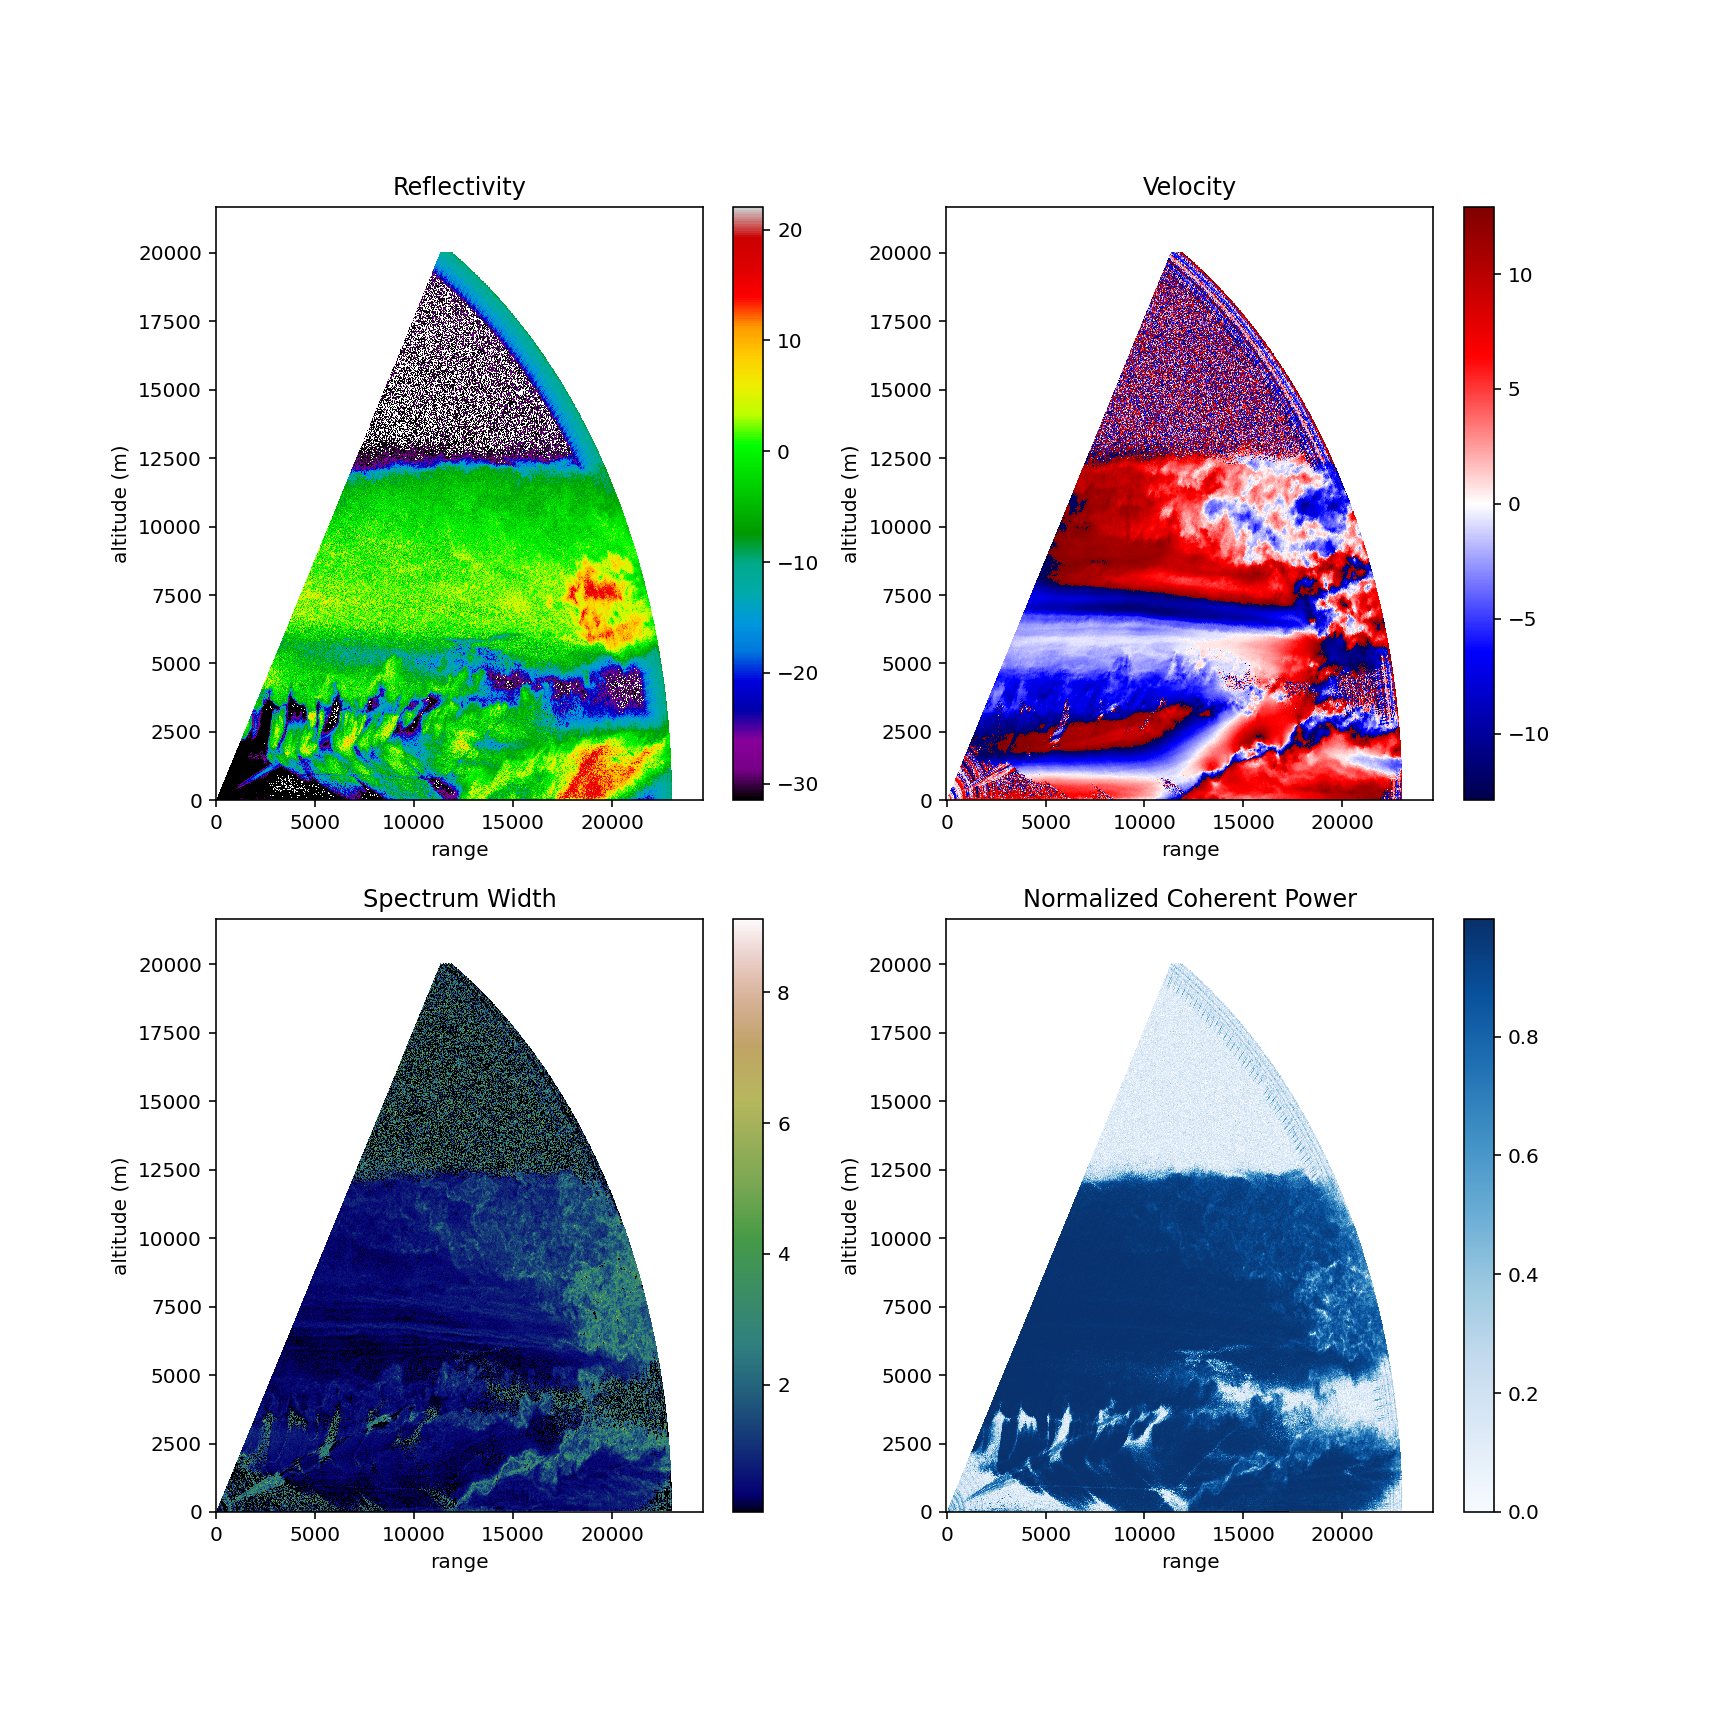

Text(0.5, 1.0, 'Normalized Coherent Power')

In [396]:
from coordinateSystems import MapProjection

# Where is the radar? What is its gate spacing?
print(d.latitude)
print(d.longitude)
print(d.range[1]-d.range[0])

# map projection setup
mp1 = MapProjection(projection='aeqd', lon_0=float(d.longitude), lat_0=float(d.latitude))
# using the map projection to covert to ECEF
X2, Y2, Z2 = mp1.fromECEF(X, Y, Z)

# shaping
X2.shape = r_2D.shape
Y2.shape = az_2D.shape
Z2.shape = el_2D.shape   

# the following is my plotting setup and plotting code
n_rows, n_cols = 2, 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(8,8))

# using pcolormesh to plot reflectivity
im = axes[0,0].pcolormesh(X2, Z2, re, cmap = 'nipy_spectral')
plt.colorbar(im, ax=axes[0,0])
axes[0,0].set_xlabel('range')
axes[0,0].set_ylabel('altitude (m)')
axes[0,0].set_title('Reflectivity')

# using pcolormesh to plot velocity
im = axes[0,1].pcolormesh(X2, Z2, vel, cmap = "seismic")
plt.colorbar(im, ax=axes[0,1])
axes[0,1].set_xlabel('range')
axes[0,1].set_ylabel('altitude (m)')
axes[0,1].set_title('Velocity')

# using pcolormesh to plot spectrum width
im = axes[1,0].pcolormesh(X2, Z2, spect_w, cmap = "gist_earth")
plt.colorbar(im, ax=axes[1,0])
axes[1,0].set_xlabel('range')
axes[1,0].set_ylabel('altitude (m)')
axes[1,0].set_title('Spectrum Width')

# using pcolormesh to plot NCP
im = axes[1,1].pcolormesh(X2, Z2, N_C_P, cmap = "Blues")
plt.colorbar(im, ax=axes[1,1])
axes[1,1].set_xlabel('range')
axes[1,1].set_ylabel('altitude (m)')
axes[1,1].set_title('Normalized Coherent Power')

<span class="ecb">You plotted the x coordinate along the projection plane instead of distance along the projection plane from x and y -2. </span>

To set the stage for the next two assignments, let's say we want to oversample the 15 m range gates to a 5 m carteisian grid in the domain 9.0…9.5 km range and 2.9…3.4 km altitude. Once again, we will use the distance above and the range along the tangent plane.

**4.** Create 2D arrays giving the corresponding center locations for each desired analysis location. Start with 1D grid box edges spanning the range above.

In [399]:
# defining a function that converts the edges to centers
def edges_to_centers_1(x):
    dx =  np.absolute(x[0]-x[1])/2
    value = np.arange(np.min(x)+dx, np.max(x)+dx-dx/2, 2*dx) #used directly from HW1
    return value

# defining our ranges of elevation and alititude given the critera within the question
range_of_altitude = np.arange(2900, 3405, 5)
range_of_elevation = np.arange(9000, 9505, 5)

# coverting the ranges of elevation and altitude to center using the above function
altitude_centers = edges_to_centers_1(range_of_altitude)
elevation_centers = edges_to_centers_1(range_of_elevation)

# here I use the centered altitude and elevation to create a meshgrid
range4, range5 = np.meshgrid(elevation_centers, altitude_centers)
# shaping 
range4.shape

# printing range values
print(range4, range5)

[[9002.5 9007.5 9012.5 ... 9487.5 9492.5 9497.5]
 [9002.5 9007.5 9012.5 ... 9487.5 9492.5 9497.5]
 [9002.5 9007.5 9012.5 ... 9487.5 9492.5 9497.5]
 ...
 [9002.5 9007.5 9012.5 ... 9487.5 9492.5 9497.5]
 [9002.5 9007.5 9012.5 ... 9487.5 9492.5 9497.5]
 [9002.5 9007.5 9012.5 ... 9487.5 9492.5 9497.5]] [[2902.5 2902.5 2902.5 ... 2902.5 2902.5 2902.5]
 [2907.5 2907.5 2907.5 ... 2907.5 2907.5 2907.5]
 [2912.5 2912.5 2912.5 ... 2912.5 2912.5 2912.5]
 ...
 [3387.5 3387.5 3387.5 ... 3387.5 3387.5 3387.5]
 [3392.5 3392.5 3392.5 ... 3392.5 3392.5 3392.5]
 [3397.5 3397.5 3397.5 ... 3397.5 3397.5 3397.5]]


**5.** For the next question, we will interpolate in three ways:
- nearest neighbor
- linear
- the traditional meteorological "Barnes" analysis (which is really a Gaussian blur fliter). 

To do so, we will use MetPy's built-in interpolators. It wraps SciPy's built-in nearest and linear interpolation methods, and adds Barnes, natural neighbor, and other interpolators. 

You will probably need to install metpy with `conda install -c conda-forge metpy`.

Once you have installed MetPy, use its `interpolate_to_points` function. Note that it takes three arguments, and those arguments require that you use `np.vstack` to rearrange the locations and data into the correct shape.

So that the Barnes analysis doesn't take forever, you will want to subset the data to only those locations that overlap with the analysis grid.

In [400]:
interpolate_to_points?

In [401]:
# from scipy.interpolate import LinearNDInterpolator, NearestNDInterpolator, griddata
# from metpy.units import units
from metpy.interpolate import interpolate_to_points

# setup for #5
# creating meshgrids and converting coords, just as we did before

(r2, el2) = np.meshgrid(r_1D, el_1D)
az_22 = np.full_like(el2, az_1D[0])

X_1, Y_1, Z_1 = r_coords.toECEF(r2, az_22, el2)
X22, Y22, Z22 = mp1.fromECEF(X_1, Y_1, Z_1)


In [402]:
# flattening out map projections
Xflat = X22.flatten()
Zflat = Z22.flatten()
print(Zflat.shape)
print(Xflat.shape)

# stacking the above flatten variables
flatten = np.vstack((Xflat, Zflat))
print(flatten.shape)

# transposing the flattened
flatT = flatten.T
print(flatT.shape)

(976276,)
(976276,)
(2, 976276)
(976276, 2)


In [403]:
# had trouble with vstack, so used hstack instead
# stacking our four variables
reflect1 = np.hstack(re)
vel1 = np.hstack(vel)
spect1 = np.hstack(spect_w)
NCP1 = np.hstack(N_C_P)

print(reflect1.shape)
print(vel1.shape)
print(spect1.shape)
print(NCP1.shape)

(976276,)
(976276,)
(976276,)
(976276,)


In [404]:
# interpolating nearest and linear

near1 = interpolate_to_points(flatT, reflect1, (range4, range5), interp_type='nearest')
near2 = interpolate_to_points(flatT, vel1, (range4, range5), interp_type='nearest')
near3 = interpolate_to_points(flatT, spect1, (range4, range5), interp_type='nearest')
near4 = interpolate_to_points(flatT, NCP1, (range4, range5), interp_type='nearest')

linear1 = interpolate_to_points(flatT, reflect1, (range4, range5), interp_type='linear')
linear2 = interpolate_to_points(flatT, vel1, (range4, range5), interp_type='linear')
linear3 = interpolate_to_points(flatT, spect1, (range4, range5), interp_type='linear')
linear4 = interpolate_to_points(flatT, NCP1, (range4, range5), interp_type='linear')

In [405]:
# defining a subsetting function with the given criteria
subsetting = np.logical_and(np.logical_and(X22 >= 9000, X22 <=9500), np.logical_and(Z22 >= 2900, Z22 <=3400))

#subsetting setup
x_sub = Xflat[subsetting]
z_sub = Zflat[subsetting]
re_sub = reflect1[subsetting]
vel_sub = vel1[subsetting]
spect_sub = spect1[subsetting]
NCP_sub = NCP1[subsetting]

# flattening, stack, and T
flatten_xz = np.vstack((x_sub, z_sub))
T_xz = flatten_xz.T

range4_flat = range4.flatten()
range5_flat = range5.flatten()
flatten_45 = np.vstack((range4_flat, range5_flat))
T_45 = flatten_45.T

# interpolating for barnes
barnes1 = interpolate_to_points(T_xz, re_sub, T_45, interp_type='barnes')
barnes2 = interpolate_to_points(T_xz, vel_sub, T_45, interp_type='barnes')
barnes3 = interpolate_to_points(T_xz, spect_sub, T_45, interp_type='barnes')
barnes4 = interpolate_to_points(T_xz, NCP_sub, T_45, interp_type='barnes')

# adjusting the shape of bbarnes
barnes1.shape = range4.shape
barnes2.shape = range4.shape
barnes3.shape = range4.shape
barnes4.shape = range4.shape

<IPython.core.display.Javascript object>


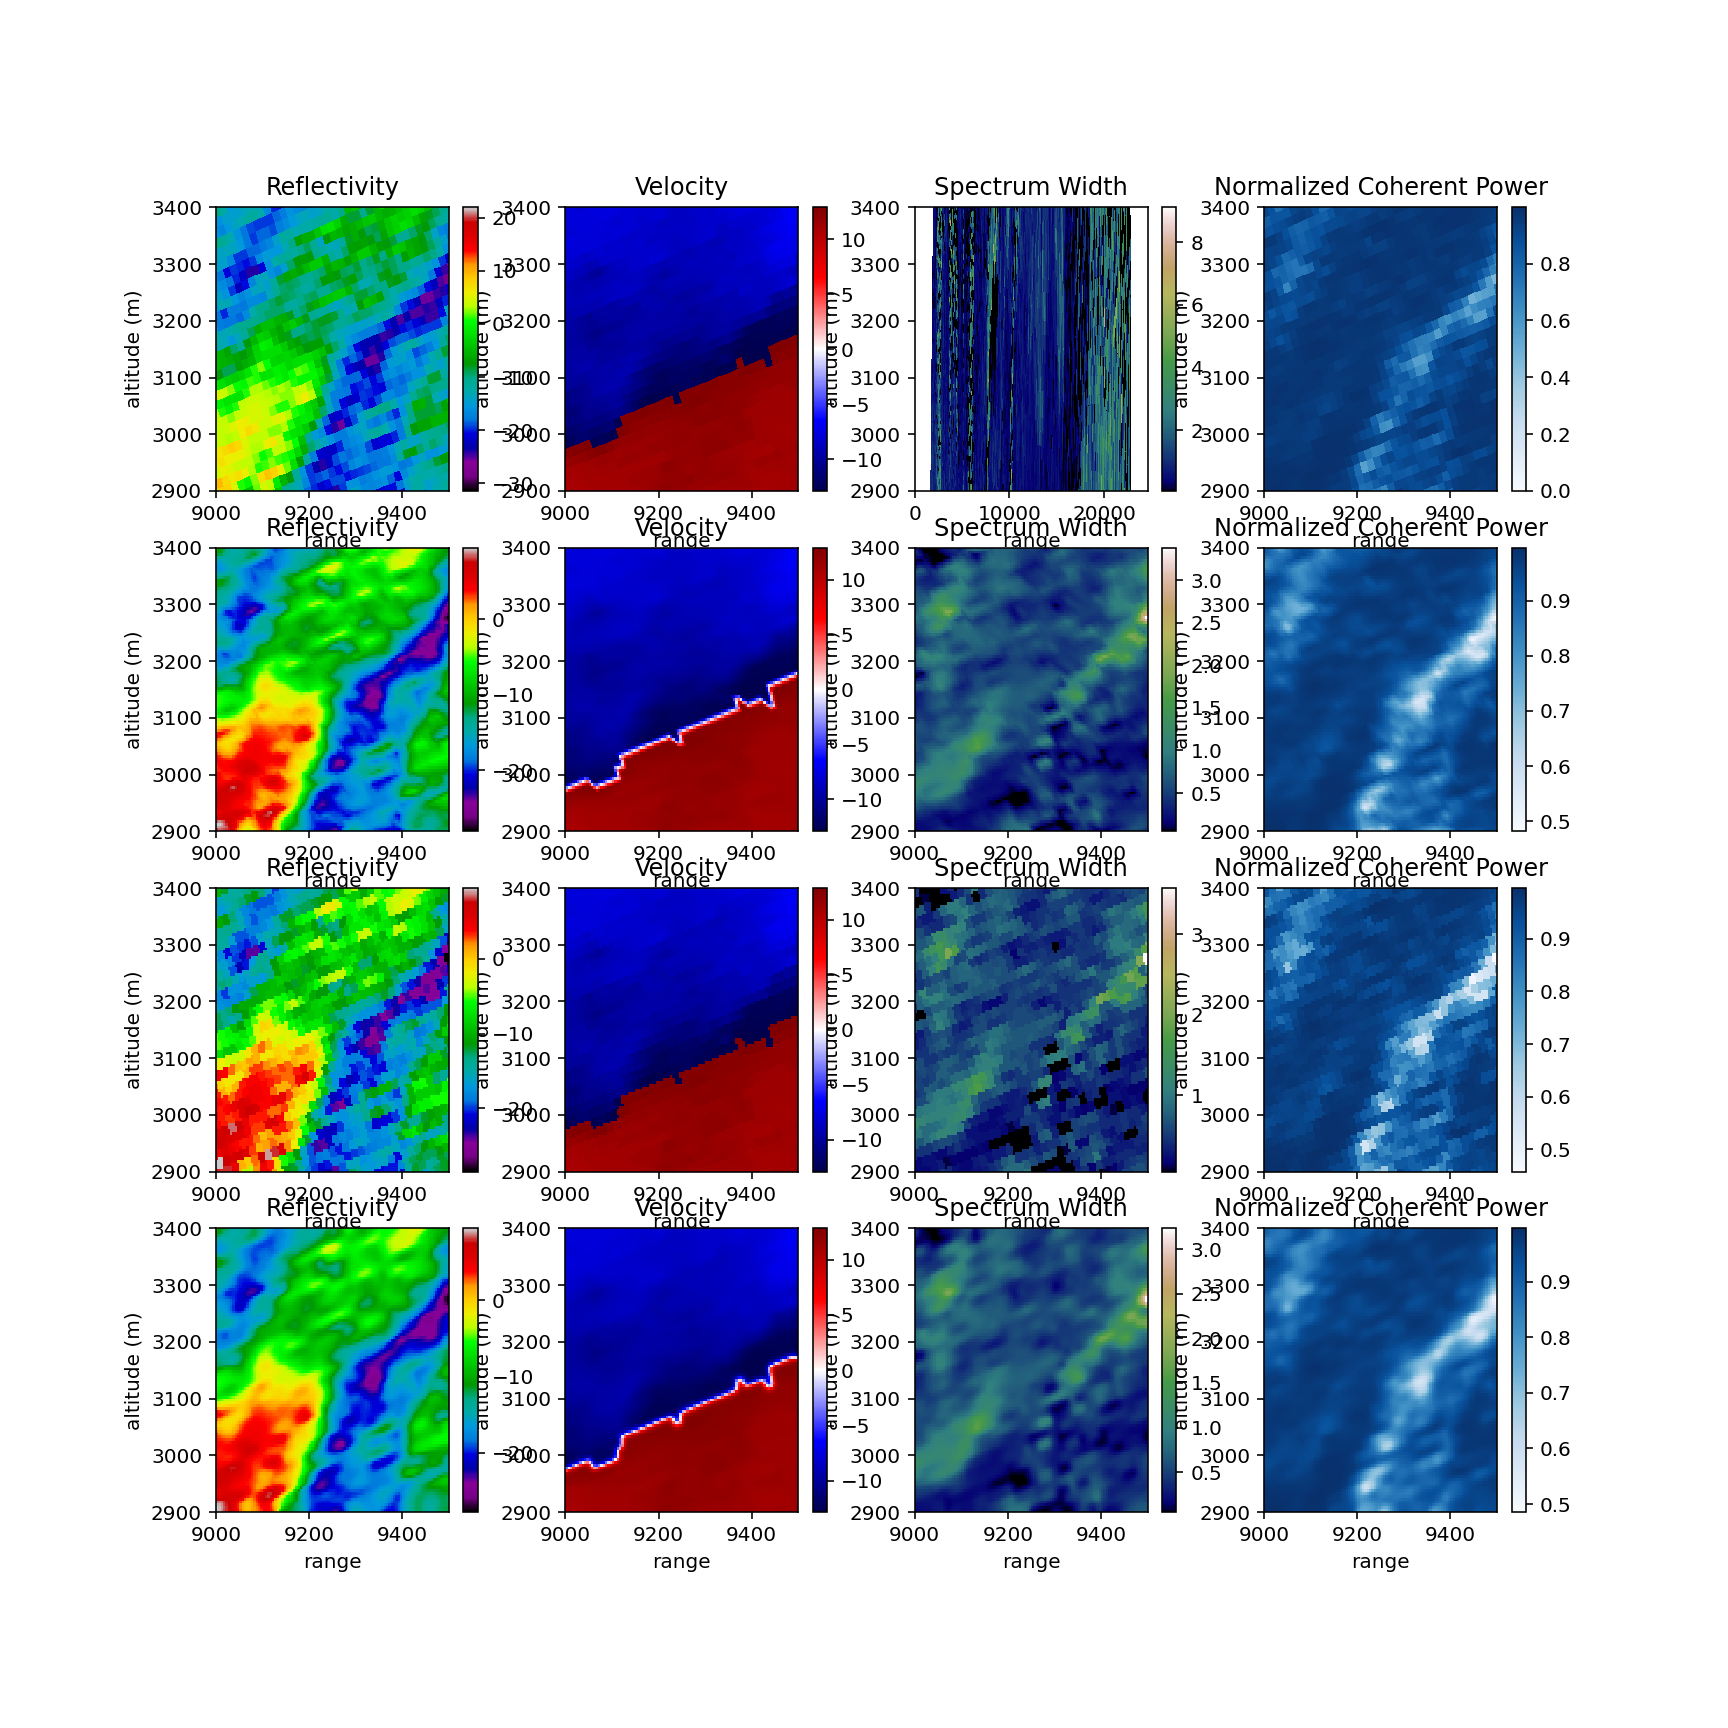

(2900.0, 3400.0)

In [406]:
#range_of_altitude 
#range_of_elevation

# the following is my plotting setup and plotting code
n_rows, n_cols = 4, 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(8,8))

# using pcolormesh to plot reflectivity
im = axes[0,0].pcolormesh(X2, Z2, re, cmap = 'nipy_spectral')
plt.colorbar(im, ax=axes[0,0])
axes[0,0].set_xlabel('range')
axes[0,0].set_ylabel('altitude (m)')
axes[0,0].set_title('Reflectivity')
axes[0,0].set_xlim([9000,9500])
axes[0,0].set_ylim([2900,3400])

# using pcolormesh to plot velocity
im = axes[0,1].pcolormesh(X2, Z2, vel, cmap = "seismic")
plt.colorbar(im, ax=axes[0,1])
axes[0,1].set_xlabel('range')
axes[0,1].set_ylabel('altitude (m)')
axes[0,1].set_title('Velocity')
axes[0,1].set_xlim([9000,9500])
axes[0,1].set_ylim([2900,3400])

# using pcolormesh to plot spectrum width
im = axes[0,2].pcolormesh(X2, Z2, spect_w, cmap = "gist_earth")
plt.colorbar(im, ax=axes[0,2])
axes[0,2].set_xlabel('range')
axes[0,2].set_ylabel('altitude (m)')
axes[0,2].set_title('Spectrum Width')
axes[0,0].set_xlim([9000,9500])
axes[0,2].set_ylim([2900,3400])

# using pcolormesh to plot NCP
im = axes[0,3].pcolormesh(X2, Z2, N_C_P, cmap = "Blues")
plt.colorbar(im, ax=axes[0,3])
axes[0,3].set_xlabel('range')
axes[0,3].set_ylabel('altitude (m)')
axes[0,3].set_title('Normalized Coherent Power')
axes[0,3].set_xlim([9000,9500])
axes[0,3].set_ylim([2900,3400])

In [407]:
# using pcolormesh to plot reflectivity
im = axes[1,0].pcolormesh(range_of_elevation, range_of_altitude, linear1, cmap = 'nipy_spectral')
plt.colorbar(im, ax=axes[1,0])
axes[1,0].set_xlabel('range')
axes[1,0].set_ylabel('altitude (m)')
axes[1,0].set_title('Reflectivity')

# using pcolormesh to plot velocity
im = axes[1,1].pcolormesh(range_of_elevation, range_of_altitude, linear2, cmap = "seismic")
plt.colorbar(im, ax=axes[1,1])
axes[1,1].set_xlabel('range')
axes[1,1].set_ylabel('altitude (m)')
axes[1,1].set_title('Velocity')

# using pcolormesh to plot spectrum width
im = axes[1,2].pcolormesh(range_of_elevation, range_of_altitude, linear3, cmap = "gist_earth")
plt.colorbar(im, ax=axes[1,2])
axes[1,2].set_xlabel('range')
axes[1,2].set_ylabel('altitude (m)')
axes[1,2].set_title('Spectrum Width')

# using pcolormesh to plot NCP
im = axes[1,3].pcolormesh(range_of_elevation, range_of_altitude, linear4, cmap = "Blues")
plt.colorbar(im, ax=axes[1,3])
axes[1,3].set_xlabel('range')
axes[1,3].set_ylabel('altitude (m)')
axes[1,3].set_title('Normalized Coherent Power')

Text(0.5, 1.0, 'Normalized Coherent Power')

In [408]:
# using pcolormesh to plot reflectivity
im = axes[2,0].pcolormesh(range_of_elevation, range_of_altitude, near1, cmap = 'nipy_spectral')
plt.colorbar(im, ax=axes[2,0])
axes[2,0].set_xlabel('range')
axes[2,0].set_ylabel('altitude (m)')
axes[2,0].set_title('Reflectivity')

# using pcolormesh to plot velocity
im = axes[2,1].pcolormesh(range_of_elevation, range_of_altitude, near2, cmap = "seismic")
plt.colorbar(im, ax=axes[2,1])
axes[2,1].set_xlabel('range')
axes[2,1].set_ylabel('altitude (m)')
axes[2,1].set_title('Velocity')

# using pcolormesh to plot spectrum width
im = axes[2,2].pcolormesh(range_of_elevation, range_of_altitude, near3, cmap = "gist_earth")
plt.colorbar(im, ax=axes[2,2])
axes[2,2].set_xlabel('range')
axes[2,2].set_ylabel('altitude (m)')
axes[2,2].set_title('Spectrum Width')

# using pcolormesh to plot NCP
im = axes[2,3].pcolormesh(range_of_elevation, range_of_altitude, near4, cmap = "Blues")
plt.colorbar(im, ax=axes[2,3])
axes[2,3].set_xlabel('range')
axes[2,3].set_ylabel('altitude (m)')
axes[2,3].set_title('Normalized Coherent Power')

Text(0.5, 1.0, 'Normalized Coherent Power')

In [409]:
# using pcolormesh to plot reflectivity
im = axes[3,0].pcolormesh(range_of_elevation, range_of_altitude, barnes1, cmap = 'nipy_spectral')
plt.colorbar(im, ax=axes[3,0])
axes[3,0].set_xlabel('range')
axes[3,0].set_ylabel('altitude (m)')
axes[3,0].set_title('Reflectivity')

# using pcolormesh to plot velocity
im = axes[3,1].pcolormesh(range_of_elevation, range_of_altitude, barnes2, cmap = "seismic")
plt.colorbar(im, ax=axes[3,1])
axes[3,1].set_xlabel('range')
axes[3,1].set_ylabel('altitude (m)')
axes[3,1].set_title('Velocity')

# using pcolormesh to plot spectrum width
im = axes[3,2].pcolormesh(range_of_elevation, range_of_altitude, barnes3, cmap = "gist_earth")
plt.colorbar(im, ax=axes[3,2])
axes[3,2].set_xlabel('range')
axes[3,2].set_ylabel('altitude (m)')
axes[3,2].set_title('Spectrum Width')

# using pcolormesh to plot NCP
im = axes[3,3].pcolormesh(range_of_elevation, range_of_altitude, barnes4, cmap = "Blues")
plt.colorbar(im, ax=axes[3,3])
axes[3,3].set_xlabel('range')
axes[3,3].set_ylabel('altitude (m)')
axes[3,3].set_title('Normalized Coherent Power')

Text(0.5, 1.0, 'Normalized Coherent Power')

**6.** Make a plot of the original data and the three interpolation methods. Compared to the original data, what do the three interpolation methods do to the data? Think about what you would regard as desirable properties of an analysis.

In [410]:
# See abbove for plots
# yes, I realize that my plotting codes are below my actual plots, but that is how I understood it best

Linear: When two adjacent points are known, the linear interpolations determine the intermediate points of the function of those adjacent points. So this interpolation uses two known values, to determine the unknown value in between.

Nearest Neighbor: nearest neighbor is not accurate becuase it causes too many position errors. NN simply determines the nearest neighbouring pixel and assumes the intensity value of it. That is why they look more pixelated.

Barnes: The barnes method takes data that is unevenly spaced and in 2D. It then passes this data twice and esentially smooths it out. 

The orginal data and nearest neighbors are n=more pixelated. Whereas the linear and barnes are smoother. In my opinion, the smoother interpolations are more desirable because they have better resoultion. 